In [47]:
import pandas as pd
from datetime import datetime, timedelta, date
import time
import matplotlib.pyplot as plt
from typing import List


#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

# Historical Quotes. The most updated start on 2023-08-04
# Lets use 6 months for historical data
quotes_start_date = date(2024, 3, 1)
df_quotes = pd.read_csv("ft_quotes.csv",index_col=0,parse_dates=True).sort_index(ascending=True).ffill().dropna(axis=1).loc[date(2023, 8, 4):]
df_quotes.index = [x.date() for x in df_quotes.index]


# Portofolio on Quotes Start Date
initial_amount = 100
encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)
df_transacoes = df_transacoes[df_transacoes['Code'].isin(df_quotes.columns)]
filter = (df_transacoes['Data de subscricao']<=quotes_start_date) & ((pd.isnull(df_transacoes['Data de resgate'])) | (df_transacoes['Data de resgate']>quotes_start_date))
df_transacoes = df_transacoes[filter]
df_transacoes['Amount'] = df_transacoes.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][quotes_start_date] * (exchange_rates.loc[quotes_start_date] if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio = df_transacoes.groupby('Code')['Amount'].sum()
df_portofolio = df_portofolio * initial_amount  / df_portofolio.sum()

# Parameters
risk_free_rate = 0.03

amount_to_buy = 20
amount_to_sell = 20
final_portfolio_amount = initial_amount + amount_to_buy - amount_to_sell
transaction_amount = 2

n_funds_to_add = 5
max_weight = 0.09

In [48]:
# Select relevant funds
df_perform = pd.read_csv("ft_funds_perform.csv", index_col=0)
relevant_funds = set(df_perform[df_perform['currency'].isin(["EUR","USD"])].index)
relevant_funds &= set([idx for idx in df_perform.index if not idx.startswith("PT")])
relevant_funds &= set(df_quotes.columns)

len(relevant_funds)

3063

In [49]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

In [50]:
#Optimization parameters
transaction_limit = 1


cov_n = 153


### Portfolio Optimization Functions

In [51]:
def new_fund_performance(new_portfolio, new_fund, amount=transaction_amount, risk_free_rate=risk_free_rate, last_n=15, goal='max_sharpe',target=None,weight_bounds = (0,1)):
    if new_fund in new_portfolio.index:
        new_portfolio.loc[new_fund] += amount
    else:
        new_portfolio.loc[new_fund] = amount

    mu = mean_historical_return(df_quotes[new_portfolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[new_portfolio.index][-cov_n:]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
    if goal=='max_sharpe':
        ef.max_sharpe(risk_free_rate=risk_free_rate)
    elif goal=='min_volatility':
        ef.min_volatility()
    elif goal=='efficient_risk':
        ef.efficient_risk(target_volatility=target)
    elif goal=='efficient_return':
        ef.efficient_return(target_return=target)
    else:
        raise ValueError('Invalid Goal!')
    return new_portfolio, ef.portfolio_performance(risk_free_rate=risk_free_rate)

def new_funds_to_add(df_portofolio, selected_funds, n_funds_to_add, last_n, goal, target=None, verbose=False, weight_bounds = (0,1)):

    mu = mean_historical_return(df_quotes[df_portofolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[df_portofolio.index][-cov_n:]).ledoit_wolf()

    ef = EfficientFrontier(mu, S, solver='SCS')
    weights = df_portofolio / df_portofolio.sum()
    ef.set_weights(weights)

    current_return, current_volatility, current_sharpe_ratio = ef.portfolio_performance(risk_free_rate=risk_free_rate)

    max_sharpe = current_sharpe_ratio
    min_volatility = current_volatility
    amount = transaction_amount
    funds_to_buy = []
    performance = None

    current_portfolio = df_portofolio.copy()
    for i in range(n_funds_to_add):
        best_fund = None
        for new_fund in selected_funds:
            try:
                _, (new_return,new_volatility,new_sharpe) = new_fund_performance(
                                                    new_portfolio=current_portfolio.copy(),
                                                    new_fund=new_fund,
                                                    last_n=last_n,
                                                    goal=goal,
                                                    target=target)
                if ((goal == 'max_sharpe') or (goal == 'efficient_risk')) and (new_sharpe > max_sharpe):
                    max_sharpe = new_sharpe
                    best_fund = new_fund
                if ((goal == 'min_volatility') or (goal == 'efficient_return')) and (new_volatility < min_volatility):
                    min_volatility = new_volatility
                    best_fund = new_fund
            except Exception as e:
                raise e
                pass
        
        if best_fund is None:
            print("\nNo more Funds found!")
            break
        else:
            funds_to_buy.append(best_fund)
            current_portfolio, performance = new_fund_performance(
                new_portfolio=current_portfolio,
                new_fund=best_fund,
                last_n=last_n,
                goal=goal,
                target=target)
            if verbose:
                print("### Performance with ", best_fund)
                print(df_perform.loc[best_fund][['ft category','name']])
                print(performance)
    return funds_to_buy, performance

def portfolio_strategy(dfi, ef, prev_strategy=None):
    cleaned_weights = ef.clean_weights()
    cleaned_weights = [(s,w) for s,w in cleaned_weights.items()]
    dfo = pd.DataFrame(cleaned_weights,columns=['Code','w']).sort_values(by='w',ascending=False)
    df = pd.merge(dfi,dfo,on=['Code'],how='outer',suffixes=('_i','_o')).fillna(0)
    if prev_strategy is not None:
        df['strategy'] =  df.apply(lambda x: prev_strategy.loc[x['Code']]['strategy'], axis=1)
    else:
        df['strategy'] = 'c'
    df['final_amount'] = df.apply(lambda x: x['amount'] if x['strategy']=='k' else x['w_o']*final_portfolio_amount, axis=1)
    df['change_amount'] = df['final_amount'] - df['amount']

    return df

def valid_date(d: date) -> date:
    if d in df_quotes.index:
        return d
    return max(dd for dd in df_quotes.index if dd <= d)

def next_date(current_date: date, transaction_interval: int = 7) -> date:
    return valid_date(current_date + timedelta(days=transaction_interval))

def fund_selection_1(current_date: date) -> set:
    old_date = valid_date(current_date - timedelta(days=14))
    df_perform['2w'] = df_quotes.loc[current_date]/df_quotes.loc[old_date]
    selected_funds = set(df_perform[df_perform.groupby('ft category')['2w'].transform('max')==df_perform['2w']].index)
    selected_funds |= set(df_perform[df_perform['rating'] >= 5].index)
    return selected_funds & relevant_funds

def strategy_step(df_portofolio: pd.Series, current_date: date, fn_selection, last_n: int, new_date: date) -> pd.Series:
    
    mu = mean_historical_return(df_quotes[df_portofolio.index].loc[valid_date(current_date - timedelta(days=last_n)):current_date])
    S = CovarianceShrinkage(df_quotes[df_portofolio.index].loc[valid_date(current_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, solver='SCS')
    weights = df_portofolio / df_portofolio.sum()
    ef.set_weights(weights)
    dfi = pd.DataFrame({'w':weights, 'amount':df_portofolio}).reset_index().sort_values(by='w',ascending=False)

    new_portfolio = df_portofolio.copy()

    funds_to_buy, performance = new_funds_to_add(
        df_portofolio=new_portfolio,
        selected_funds=fn_selection(current_date=current_date), 
        n_funds_to_add=n_funds_to_add,
        last_n=last_n,
        goal='max_sharpe',
        verbose=False,
        weight_bounds=(0,max_weight))

    new_p = new_portfolio.index.append(pd.Index(funds_to_buy))

    mu = mean_historical_return(df_quotes[new_p].loc[valid_date(current_date - timedelta(days=last_n)):current_date])
    S = CovarianceShrinkage(df_quotes[new_p].loc[valid_date(current_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=(0,max_weight), solver='SCS')
    ef.max_sharpe(risk_free_rate=risk_free_rate)

    df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')

    weight_bounds = list()
    buy_list = list()
    for i, code in enumerate(df_quotes[new_p].columns):
        if abs(df.loc[code]['change_amount']) < transaction_limit:
            weight_bounds.append((df.loc[code]['w_i'],df.loc[code]['w_i'])) # Keep
        elif df.loc[code]['change_amount'] >= 0.0:
            weight_bounds.append((df.loc[code]['w_i'],max_weight)) # keep or buy
        else:
            weight_bounds.append((0.0,df.loc[code]['w_i'])) #keep or sell
        if df.loc[code]['change_amount'] >= 0.0:
            buy_list.append((i,df.loc[code]['w_i']))

    mu = mean_historical_return(df_quotes[new_p].loc[valid_date(current_date - timedelta(days=last_n)):current_date])
    S = CovarianceShrinkage(df_quotes[new_p].loc[valid_date(current_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
    # Limit the amount to buy
    buy_final_w = (sum([w_i for _,w_i in buy_list])*initial_amount + amount_to_buy) / final_portfolio_amount
    ef.add_constraint(lambda x : sum([x[i] for i,_ in buy_list]) == buy_final_w)
    ef.max_sharpe(risk_free_rate=risk_free_rate)

    df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')
    df['w_o'] = df.apply(lambda x: x['w_i'] if abs(x['change_amount'])<transaction_limit else x['w_o'], axis = 1)
    r = 1- (df['w_o'].sum()-1) / df[(df['w_o']!=df['w_i'])]['w_o'].sum()
    df['w_o'] = df.apply(lambda x: x['w_o']*(1 if x['w_o']==x['w_i'] else r) ,axis=1)

    ds = df['w_o']*df['amount'].sum()
    ds = ds[ds!=0]
    ds.name = 'amount'

    df = ds.reset_index()
    df['new_amount'] = df.apply(lambda x: x['amount']*df_quotes[x['Code']][new_date]/df_quotes[x['Code']][current_date],axis=1)
    
    return df.set_index('Code')['new_amount']

2024-02-15
2024-02-22
2024-02-29
2024-03-07
2024-03-14
2024-03-21
2024-03-28
2024-04-04
2024-04-11
2024-04-18
2024-04-25


<Axes: xlabel='date'>

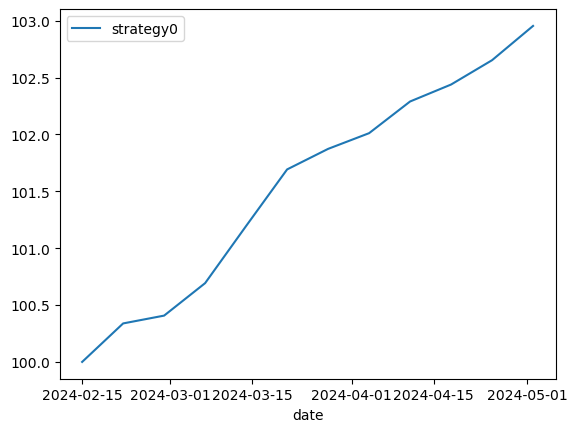

In [52]:
current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

while new_date < df_quotes.index.max():
    print(current_date)
    df_prtf = strategy_step(df_portofolio=df_prtf,current_date=current_date,fn_selection=fund_selection_1, last_n=21,new_date=new_date)
    value_lst.append((new_date,df_prtf.sum()))
    current_date = new_date
    new_date = next_date(current_date)

results_df = pd.DataFrame(data=value_lst,columns=['date','strategy0']).set_index('date')
results_df.plot()

In [55]:
def fund_selection_2(current_date: date) -> set:
    old_date1 = valid_date(current_date - timedelta(days=14))
    old_date2 = valid_date(current_date - timedelta(days=28))
    df_perform['2w'] = (df_quotes.loc[current_date]/df_quotes.loc[old_date1])*2-(df_quotes.loc[current_date]/df_quotes.loc[old_date2])
    selected_funds = set(df_perform[df_perform.groupby('ft category')['2w'].transform('max')==df_perform['2w']].index)
    #selected_funds |= set(df_perform[df_perform['rating'] >= 5].index)
    return selected_funds & relevant_funds

In [63]:
def my_mean_historical_return(fund_list, current_date):
    return df_quotes[fund_list].loc[current_date] / df_quotes[fund_list].loc[valid_date(current_date - timedelta(days=21))] -1

my_mean_historical_return(df_portofolio.index, valid_date(d=quotes_start_date))

IE00BDRKSX26    0.019362
IE00BLP5S460    0.000000
LU0106235376    0.015943
LU0173776047    0.002865
LU0235843108    0.011777
LU0329070915    0.102436
LU0390137973    0.053686
LU0414665884    0.028037
LU0627762692    0.004838
LU0705071453    0.005796
LU0875418195   -0.002608
LU1046234842    0.008985
LU1161527038   -0.002296
LU1176912761   -0.009057
LU1244139660    0.041157
LU1373035150    0.009579
LU1495982271   -0.006891
LU1508158513    0.022953
LU1520759108   -0.019540
LU1728556959    0.008902
LU1735753946    0.003521
LU1883334275    0.003837
LU1915690918    0.006834
dtype: float64

In [67]:
prices = df_quotes[df_portofolio.index].loc[valid_date(current_date - timedelta(days=21)):current_date]
returns = prices.pct_change().dropna(how="all")
(1 + returns).prod() ** (252 / returns.count()) - 1

IE00BDRKSX26    3.801253e-01
IE00BLP5S460   -1.887379e-15
LU0106235376    3.043787e-01
LU0173776047    4.924274e-02
LU0235843108    2.173745e-01
LU0329070915    4.146777e+00
LU0390137973    1.407396e+00
LU0414665884    5.912748e-01
LU0627762692    8.445293e-02
LU0705071453    1.019673e-01
LU0875418195   -4.291979e-02
LU1046234842    1.621538e-01
LU1161527038   -3.787355e-02
LU1176912761   -1.417411e-01
LU1244139660    9.691166e-01
LU1373035150    1.736984e-01
LU1495982271   -1.096767e-01
LU1508158513    4.641237e-01
LU1520759108   -2.821738e-01
LU1728556959    1.605490e-01
LU1735753946    6.082937e-02
LU1883334275    6.645610e-02
LU1915690918    1.212223e-01
dtype: float64

In [62]:
current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

mean_historical_return(df_quotes[df_portofolio.index].loc[valid_date(current_date - timedelta(days=21)):current_date])


IE00BDRKSX26    3.801253e-01
IE00BLP5S460   -1.887379e-15
LU0106235376    3.043787e-01
LU0173776047    4.924274e-02
LU0235843108    2.173745e-01
LU0329070915    4.146777e+00
LU0390137973    1.407396e+00
LU0414665884    5.912748e-01
LU0627762692    8.445293e-02
LU0705071453    1.019673e-01
LU0875418195   -4.291979e-02
LU1046234842    1.621538e-01
LU1161527038   -3.787355e-02
LU1176912761   -1.417411e-01
LU1244139660    9.691166e-01
LU1373035150    1.736984e-01
LU1495982271   -1.096767e-01
LU1508158513    4.641237e-01
LU1520759108   -2.821738e-01
LU1728556959    1.605490e-01
LU1735753946    6.082937e-02
LU1883334275    6.645610e-02
LU1915690918    1.212223e-01
dtype: float64

<Axes: xlabel='date'>

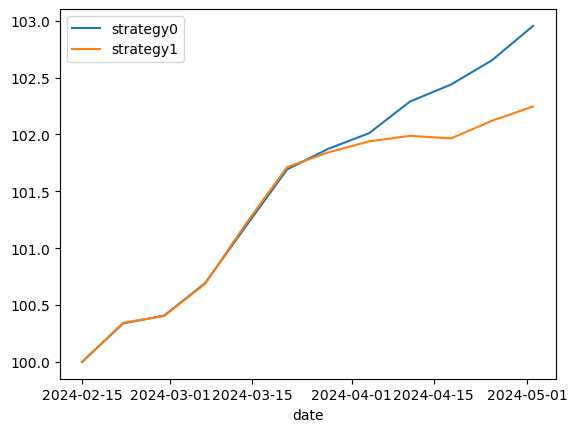

In [58]:
results_df.join(results1_df).plot()